<a href="https://colab.research.google.com/github/ankp6737/machinelearning/blob/main/Univariate_Time_Series_Prediction_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Time Series Forecast using LSTM**

##Importing Libraries

In [46]:
import pandas as pd #import library that helps in data manipulation and analysis. This library will be referred as pd in future program
import numpy as np  #import library that is used for working with arrays
%matplotlib inline   
import matplotlib.pyplot as plt  #import library for plotting graphs

## Loading the Dataset

In [47]:
df = pd.read_csv('/content/drive/MyDrive/Data/Product_Sales.csv',index_col='DATE',parse_dates=True) #load the dataset
df.index.freq = 'MS'    #Shift index by desired number of time frequency increments, 'MS':Month Start.
df.head()               #print first few rows of the dataset

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


##Visualizing the Data

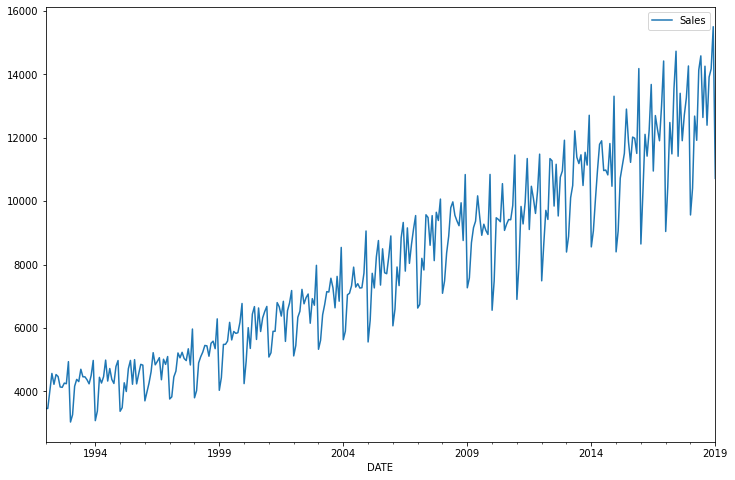

In [48]:
df.columns = ['Sales']      #change name of coloumn to 'Sales'
df.plot(figsize=(12,8))     #plotting the dataset

##Transforming Data

###Seasonal Decomposing the Data

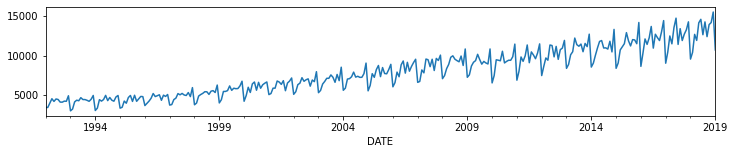

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose     #importing library for performing seasonal decompose

results = seasonal_decompose(df['Sales'],model='additive')      #performing the seasonal decompose on the dataset
results.observed.plot(figsize=(12,2))                           #plot the obsereved component of the seasonal decomposition

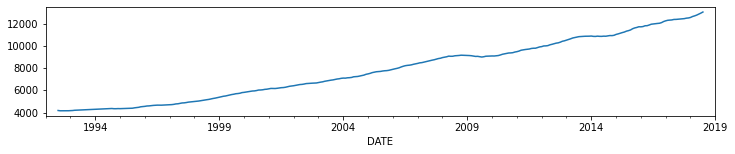

In [50]:
results.trend.plot(figsize=(12,2))        #plot the trend component of the seasonal decomposition

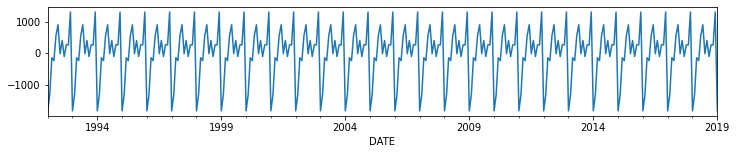

In [51]:
results.seasonal.plot(figsize=(12,2))     #plot the seasonal component of the seasonal decomposition

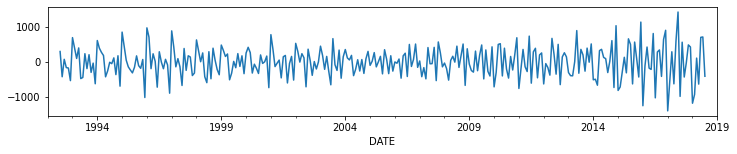

In [52]:
results.resid.plot(figsize=(12,2))    #plot the residual component of the seasonal decomposition

###Splitting the data

In [64]:
print("len(df)", len(df))       #print the length of the original dataset

train = df.iloc[:313]           #split the dataset into train data
test = df.iloc[313:]            #split the dataset into test data


print("len(train)", len(train))  #print the length of train data
print("len(test)", len(test))    #print the length of test data

len(df) 325
len(train) 313
len(test) 12


###Scaling the Data

In [65]:
from sklearn.preprocessing import MinMaxScaler    #import library for Min Max scaling

scaler = MinMaxScaler()                             #defining the minmax scaler

# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)   #Compute the minimum and maximum to be used for later scaling.

MinMaxScaler(copy=True, feature_range=(0, 1))

In [55]:
scaled_train = scaler.transform(train)    #	Scale features of train according to feature_range.
scaled_test = scaler.transform(test)      #	Scale features of test according to feature_range.

##Generating Time Series Data

Time series data must be transformed into a structure of samples with input and output components before it can be used to fit a supervised learning model.

A supervised learning algorithm requires that data is provided as a collection of samples, where each sample has an input component (X) and an output component (y).

For a univariate time series interested in one-step predictions, the observations at prior time steps, so-called lag observations, are used as input and the output is the observation at the current time step.

Keras provides the TimeseriesGenerator that can be used to automatically transform a univariate or multivariate time series dataset into a supervised learning problem.


In [56]:
from keras.preprocessing.sequence import TimeseriesGenerator    #import library for timeseries generator

In [59]:
# Create TimeseriesGenerator object for training dataset (define how long the trainig sequence to be (n_input) and the very next point to predict)
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

# What does the first batch look like?
X,y = generator[0]

print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.03658432 0.03649885 0.08299855 0.13103684 0.1017181  0.12804513
 0.12266006 0.09453799 0.09359774 0.10496624 0.10334217 0.16283443]
Predict this y: 
 [[0.]]


In the above n_feature should be decided based on seasonality, if seasonality is based over the year, then as it is monthly dataset, so, n_feature should be at least 12, in order for RNN to pickup at least seasonality

##Defining the Model

In [61]:
from keras.models import Sequential                           #import library for arranging the Keras layers in a sequential order
from keras.layers import Dense                                #import library for dense layer. Dense layer is the regular deeply connected neural network layer.
from keras.layers import LSTM                                 #import library for LSTM

# define model
model = Sequential()                                          #create a sequential model
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))  #adding input layer to the model
model.add(Dense(1))                                                         #adding dense layer to the model
model.compile(optimizer='adam', loss='mse')                                 #using 'adam' optimizer and 'mean square error' for loss'
model.summary()                                                             #printing the summary of the model created

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


##Training the Model

In [62]:
# fit model
model.fit_generator(generator,epochs=50)    #training the model with 50 epochs

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
301/301 [==============================] - 3s 6ms/step - loss: 0.0594
Epoch 2/50
301/301 [==============================] - 2s 6ms/step - loss: 0.0123
Epoch 3/50
301/301 [==============================] - 2s 6ms/step - loss: 0.0082
Epoch 4/50
301/301 [==============================] - 2s 6ms/step - loss: 0.0077
Epoch 5/50
301/301 [==============================] - 2s 6ms/step - loss: 0.0075
Epoch 6/50
301/301 [==============================] - 2s 6ms/step - loss: 0.0088
Epoch 7/50
301/301 [==============================] - 2s 6ms/step - loss: 0.0058
Epoch 8/50
301/301 [==============================] - 2s 6ms/step - loss: 0.0046
Epoch 9/50
301/301 [==============================] - 2s 6ms/step - loss: 0.0038
Epoch 10/50
301/301 [==============================] - 2s 6ms/step - loss: 0.0033
Epoch 11/50
301/301 [==============================] - 2s 6ms/step - loss: 0.0022
Epoch 12/50
301/301 [==============================] - 2s 6ms/step - loss: 0.0017
Epoch 13/50
301/301 [====

###Plot the Loss per Epoch

Text(0, 0.5, 'Loss')

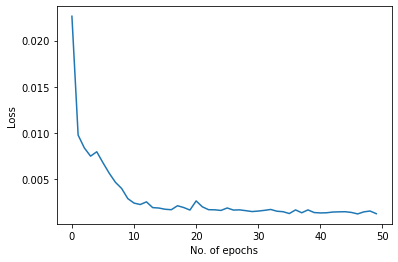

In [63]:
model.history.history.keys()                      #History.history attribute is a record of training loss values and metrics values at successive epochs
loss_per_epoch = model.history.history['loss']    #storing the loss values at each epoch
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)   #plotting the loss values vs number of epoc
plt.xlabel("No. of epochs")
plt.ylabel("Loss")

##Predict using the model

For predicting the first data in test set we need the last 12 data points from the test dataset

In [66]:
first_eval_batch = scaled_train[-12:]   #copying the last 12 data points 
first_eval_batch

array([[0.63432772],
       [0.80776135],
       [0.72313873],
       [0.89870929],
       [1.        ],
       [0.71672793],
       [0.88648602],
       [0.75869732],
       [0.82742115],
       [0.87443371],
       [0.96025301],
       [0.5584238 ]])

In [69]:
# holding my predictions
test_predictions = []
# last n_input points from training set
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))  # reshaping first_eval_batch as the input which is being passed to TimeseriesGenerator must be 3D (batch_size, n_input, n_features) 

# how far into future will I forecast
for i in range(len(test)):
    
   # one timestep ahead of historical 12 points
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
len(test_predictions)

12

###Inverse Transformations and Compare

In [37]:
true_predictions = scaler.inverse_transform(test_predictions) # Performing reverse scaling on the test predictions
true_predictions

array([[11574.77004582],
       [12889.43425924],
       [12429.97288024],
       [14391.99132377],
       [15167.09640336],
       [12229.1253159 ],
       [14042.40792018],
       [12477.19921827],
       [13490.24551976],
       [13937.67752218],
       [14785.89535487],
       [10389.67458141]])

In [38]:
test['Predictions'] = true_predictions  # Add prediction column to dataset
test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Sales,Predictions
DATE,,
2018-02-01,10415,11574.770046
2018-03-01,12683,12889.434259
2018-04-01,11919,12429.972880
2018-05-01,14138,14391.991324
2018-06-01,14583,15167.096403
2018-07-01,12640,12229.125316
2018-08-01,14257,14042.407920
2018-09-01,12396,12477.199218
2018-10-01,13914,13490.245520


###Plot the prediction

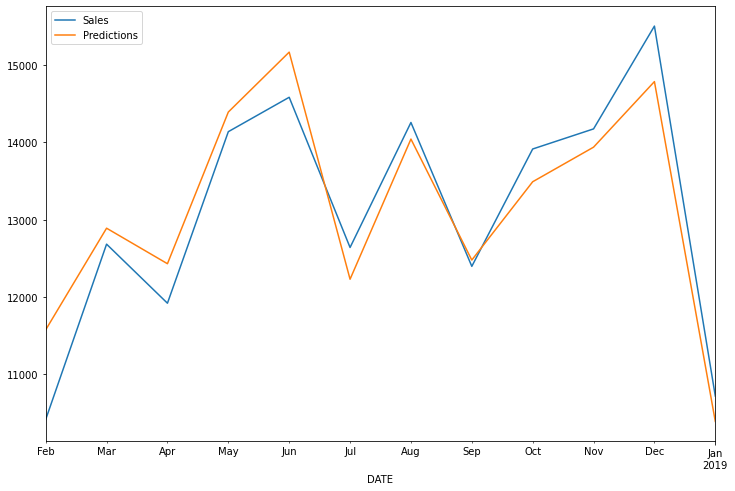

In [39]:
test.plot(figsize=(12,8))   #plot the actual sales and predicted sales using LSTM

##Evaluate the Model

In [40]:
from sklearn.metrics import r2_score

r2 = r2_score(test['Sales'], test['Predictions'])
r2  

0.8854574310600593

##Forecast using the model

###Train the model

It is mainly the same code, except where future dates are added on.

In [41]:
train = df
scaler.fit(train)
train = scaler.transform(train)
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)
model.fit_generator(generator,epochs=50)
pred_list = []  
batch = train[-n_input:].reshape((1, n_input, n_features))
for i in range(n_input):
    pred_list.append(model.predict(batch)[0])      
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

Epoch 1/50
15/53 [=======>......................] - ETA: 0s - loss: 0.0010

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


53/53 [==============================] - 0s 7ms/step - loss: 0.0010
Epoch 2/50
53/53 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 3/50
53/53 [==============================] - 0s 8ms/step - loss: 0.0010
Epoch 4/50
53/53 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 5/50
53/53 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 6/50
53/53 [==============================] - 0s 7ms/step - loss: 0.0010
Epoch 7/50
53/53 [==============================] - 0s 8ms/step - loss: 9.7791e-04
Epoch 8/50
53/53 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 9/50
53/53 [==============================] - 0s 8ms/step - loss: 0.0010
Epoch 10/50
53/53 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 11/50
53/53 [==============================] - 0s 8ms/step - loss: 0.0010
Epoch 12/50
53/53 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 13/50
53/53 [==============================] - 0s 

###Generate future Dates

Here, we create our new dates for the next 12 months.

In [42]:
from pandas.tseries.offsets import DateOffset
add_dates = [df.index[-1] + DateOffset(months=x) for x in range(0,13) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=df.columns)

###Perform inverse transform

It is same as inverse transform except that index is set to future dates

In [43]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-n_input:].index, columns=['Prediction'])

df_proj = pd.concat([df,df_predict], axis=1)

###Plot the forecast

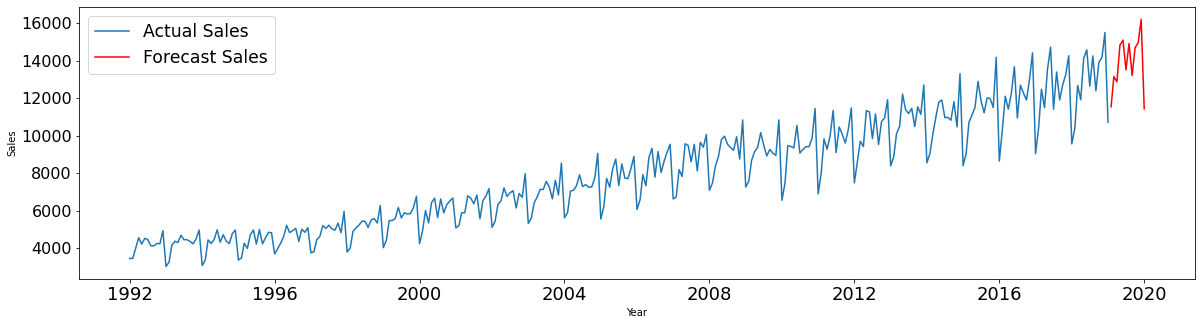

In [75]:
plt.figure(figsize=(20, 5))
plt.plot(df_proj.index, df_proj['Sales'])
plt.plot(df_proj.index, df_proj['Prediction'], color='r')
plt.legend(['Actual Sales','Forecast Sales'],loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel("Year")
plt.ylabel("Sales")
plt.show()